In [6]:
# --- Imports ---
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
# --- Optional Debugging ---
def check_random_samples_from_list(text_list, keyword, n_samples=1000):
    import random
    sample_size = min(n_samples, len(text_list))
    random.seed(42)
    sample_texts = random.sample(text_list, sample_size)
    with_kw = [t for t in sample_texts if keyword.lower() in t.lower()]
    without_kw = [t for t in sample_texts if keyword.lower() not in t.lower()]
    percent = (len(with_kw) / sample_size) * 100
    print(f"{len(with_kw)}/{sample_size} ({percent:.2f}%) contain the keyword")
    return percent, with_kw, without_kw

In [8]:
# Load a pretrained Georgian sentiment model
model_name = "Arseniy-Sandalov/GeorgianBert-Sent"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Explicit class ID to label mapping
label_map = {
    0: "mixed",
    1: "positive", 
    2: "neutral",
    3: "negative"
}

# Move model to GPU
model.to("cuda")
model.eval()

def predict_sentiment_batch(texts, batch_size=32):
    sentiments = []
    dataloader = DataLoader(texts, batch_size=batch_size)

    for batch in tqdm(dataloader, desc="Predicting sentiment"):
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1).cpu().tolist()
            sentiments.extend([label_map[p] for p in preds])

    return sentiments

In [ ]:
# Plotting sentiment distribution
def plot_sentiment_distribution(df, sentiment_column='sentiment'):
    sentiment_counts = df[sentiment_column].value_counts().reindex(
        ["mixed", "positive", "neutral", "negative"]
    ).fillna(0)

    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='bar', color=['orange', 'green', 'gray', 'red'])
    plt.title("Sentiment Distribution in Georgian Media (Keyword Contexts)")
    plt.ylabel("Number of Publications")
    plt.xlabel("Sentiment")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

Loading processed data from data/processed_corpus.parquet...


Predicting sentiment: 100%|██████████| 497/497 [08:40<00:00,  1.05s/it]


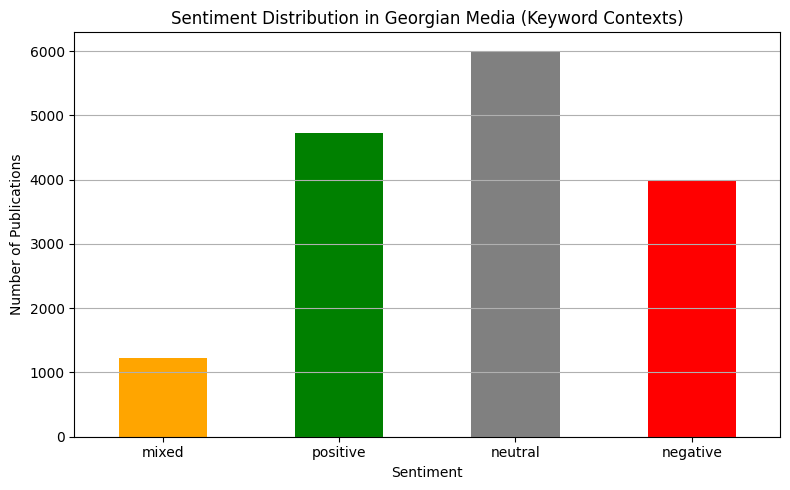

In [10]:
import os

processed_file = 'data/processed_corpus.parquet'

if os.path.exists(processed_file):
    print(f"Loading processed data from {processed_file}...")
    df = pd.read_parquet(processed_file)

# Predict sentiment
df['sentiment'] = predict_sentiment_batch(df['context_text'].tolist())

# Visualize
plot_sentiment_distribution(df)


In [ ]:
# View sample results
df[df['sentiment'] == 'positive'][['context_text']].sample(5)
df[df['sentiment'] == 'neutral'][['context_text']].sample(5)
df[df['sentiment'] == 'negative'][['context_text']].sample(5)

,context_text
10000,— ამის მიზეზი შეიძლება დინოზავრები იყვნენ რატო...
12756,მოკლე აღწერა:მოზარდი ობოლი ეძებს თავშესაფარს ს...
13657,„ნენსკრა ჰესი“ – ერთ–ერთი მსხვილი საფუძველია ჩ...
171,"როგორც დეველოპერი ამბობს, მათ გეიმერებს მოუსმი..."
1935,გაიგეთ კომპიუტერის ხედვისა და ს მექანიკა ჰარვა...


In [12]:
sentiment_counts = df['sentiment'].value_counts().reindex(
    ["mixed", "positive", "neutral", "negative"]
).fillna(0).astype(int)

# Print the results
print("Sentiment Distribution (Document Counts):")
print(sentiment_counts)

Sentiment Distribution (Document Counts):
sentiment
mixed       1221
positive    4718
neutral     5991
negative    3974
Name: count, dtype: int64
